This notebook runs through my thoughts and workflow for creating a model to predict patient volumes in the Puget Sound region for Providence Health and Services.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

There are seven regions to analyze. I'll focus on Puget sound since I live and work here. First, I'm curious how my region volumes compare to others.

In [2]:
df = pd.read_csv('D:\Documents\Work\PSPH\Volumes\Data\\weekly_volumes.csv')
df.head()

,Admit Week Date,End of Week Display Date,All Ministries,Alaska,NorCal,Oregon,Puget Sound,SoCal,Texas/NM,WA/MT
0,12/31/2017,1/6/2018,116661,4171,10160,29348,22181,28940,4664,17197
1,1/7/2018,1/13/2018,131198,4351,11206,35497,24924,30474,5069,19677
2,1/14/2018,1/20/2018,131382,4467,10085,37578,24304,30397,4876,19675
3,1/21/2018,1/27/2018,130872,4347,10449,36740,24295,29118,5112,20811
4,1/28/2018,2/3/2018,133769,4615,12048,34609,24187,32468,5718,20124


Text(0.5, 1.0, 'Patient Volumes by Region')

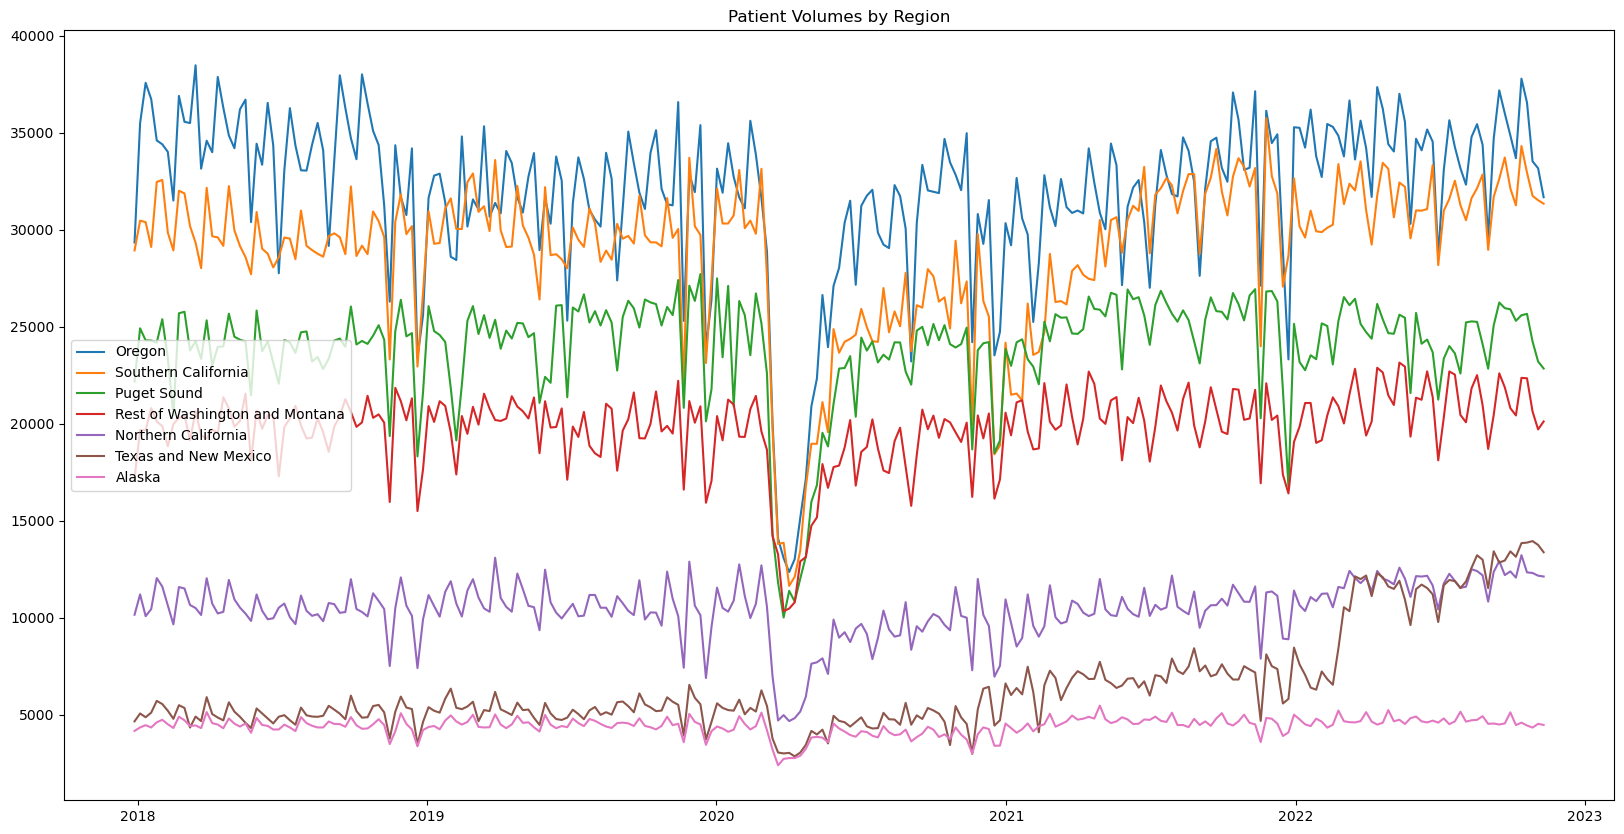

In [3]:
# one big plot of all regions
t = np.arange("2017-12-31", "2022-11-19", dtype = "datetime64[W]")
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(t, df['Oregon'], label = 'Oregon')
ax.plot(t, df['SoCal'], label = 'Southern California')
ax.plot(t, df['Puget Sound'], label = 'Puget Sound')
ax.plot(t, df['WA/MT'], label = 'Rest of Washington and Montana')
ax.plot(t, df['NorCal'], label = 'Northern California')
ax.plot(t, df['Texas/NM'], label = 'Texas and New Mexico')
ax.plot(t, df['Alaska'], label = 'Alaska')
ax.legend(loc = 'center left')
ax.set_title('Patient Volumes by Region')

The large drop in volumes for all regions is the beginning of Covid-19 era lockdowns. Nearly all outpatient procedures were canceled at this time, and there was widely documented fear among the public of entering hospitals at all. In the Texas/New Mexico region, a new hospital was added in early 2022.
Next we will look at the feasibility of fitting a simple ARIMA model for the Puget Sound region.

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

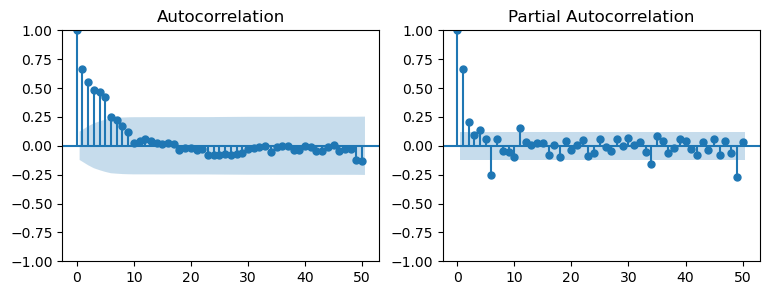

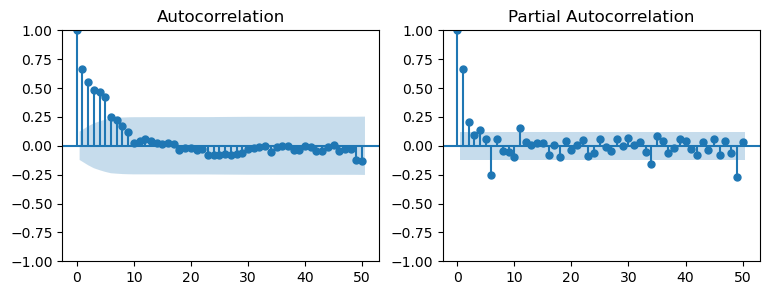

In [5]:
fig, axes = plt.subplots(1,2,figsize=(9,3), dpi= 100)
plot_acf(df['Puget Sound'], lags=50, ax=axes[0])
plot_pacf(df['Puget Sound'], lags=50, ax=axes[1])

Ignoring the 'always 1' 0th lag, we have 5 significant and decreasing first lags in the ACF and 2 in the PACF. Both MA and AR terms are warranted and we will attempt multiple model fits. There is no need to detrend, difference or account for seasonality.

In [6]:
from statsmodels.tsa.arima.model import ARIMA

In [7]:
# ARIMA(2,0,1) model
model = ARIMA(df['Puget Sound'], order = (2,0,1))
model1 = model.fit()
print(model1.summary())

# ARIMA(1,0,5) model
model = ARIMA(df['Puget Sound'], order = (1,0,5))
model3 = model.fit()

# ARIMA(1,0,1) model
model = ARIMA(df['Puget Sound'], order = (1,0,1))
model2 = model.fit()

                               SARIMAX Results                                
Dep. Variable:            Puget Sound   No. Observations:                  255
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -2306.012
Date:                Fri, 09 Dec 2022   AIC                           4622.024
Time:                        10:56:09   BIC                           4639.730
Sample:                             0   HQIC                          4629.146
                                - 255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.394e+04    737.800     32.452      0.000    2.25e+04    2.54e+04
ar.L1          0.9639      0.245      3.936      0.000       0.484       1.444
ar.L2         -0.0841      0.169     -0.498      0.6

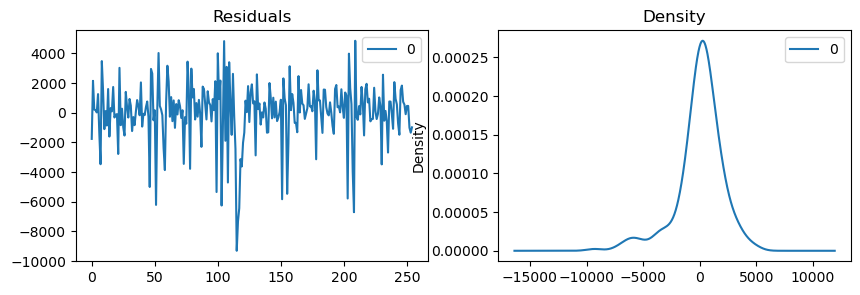

In [8]:
# residuals model 1
res = pd.DataFrame(model1.resid)
fig, ax = plt.subplots(1,2, figsize = (10,3))
res.plot(title="Residuals", ax=ax[0])
res.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The information criteria don't provide a clear consensus on which model is better (see the Appendix at the end of this document to see the full model outputs). We can test the models' performances on 'unseen' data by using it to predict values from any time in the series. Below we try to predict the most recent 5 weeks with an ARIMA(1,0,5) model, which had the lowest AIC, and an ARIMA(1,0,1) model, which had the lowest BIC.

In [9]:
# create 'training' and 'testing' set
train = df['Puget Sound'][:250]
test = df['Puget Sound'][250:]

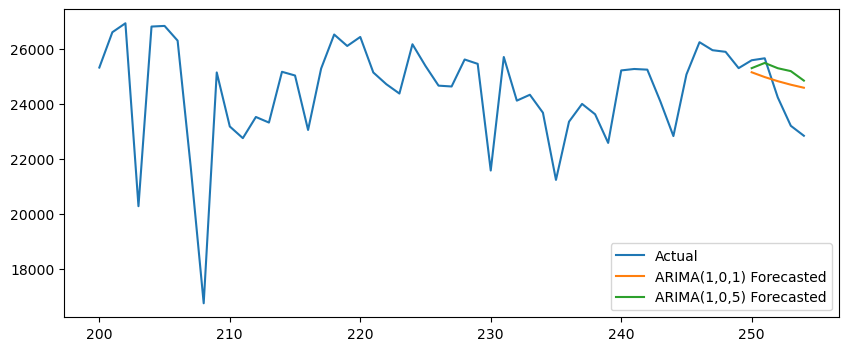

In [10]:
model2 = ARIMA(train, order = (1,0,1))
fits2 = model2.fit()
model3 = ARIMA(train, order = (1,0,5))
fits3 = model3.fit()

# forecast
fc2 = fits2.forecast(5)
fc2_series = pd.Series(fc2, index = test.index)
fc3 = fits3.forecast(5)
fc3_series = pd.Series(fc3, index = test.index)

# plot
plt.figure(figsize = (10,4))
plt.plot(df.loc[200:254, ['Puget Sound']], label = 'Actual')
plt.plot(fc2_series, label = 'ARIMA(1,0,1) Forecasted')
plt.plot(fc3_series, label = 'ARIMA(1,0,5) Forecasted')
plt.legend()
plt.show()

We can test the accuracy of each model using Mean Absolute Percentage Error (MAPE) for all three models above.

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
def pred_acc(p, d, q, steps, split):
    train = df['Puget Sound'][:split]
    test = df['Puget Sound'][split:split+steps]
    model = ARIMA(train, order = (p,d,q))
    fits = model.fit()
    forecast = fits.forecast(steps)
    return(np.mean(np.abs(forecast - test.values)/np.abs(test.values))) # MAPE

mape_results = [0]*3
mape_results[0] = pred_acc(2,0,1,5,250)
mape_results[1] = pred_acc(1,0,1,5,250)
mape_results[2] = pred_acc(1,0,5,5,250)
print(mape_results)

[0.0424171600918939, 0.04175993726664069, 0.046997494509151735]


The ARIMA(1,0,1) model is most accurate in this sample. The most complicated (ARIMA(1,0,5)) is the worst, about 0.5% off the high mark. What about other periods of time? Which model performs best predicting the rise from the bottom of the Covid-19 related trough? This time we predict 10 time periods.

In [13]:
def time_testing(splittime):
    mape_results = [0]*3
    mape_results[0] = round(pred_acc(2,0,1,10,splittime), 4)
    mape_results[1] = round(pred_acc(1,0,1,10,splittime), 4)
    mape_results[2] = round(pred_acc(1,0,5,10,splittime), 4)
    print('(2,0,1) (1,0,1) (1,0,5)')
    print(mape_results)
time_testing(118)

(2,0,1) (1,0,1) (1,0,5)
[0.4002, 0.3927, 0.4518]


The simplest model is again the most accurate (not saying much, as it average an error of 39% during this period), but this time period is fairly simple, starting from the bottom of the absolute minimum and nearly only increasing. What about a few other times?

In [14]:
time_testing(95)

(2,0,1) (1,0,1) (1,0,5)
[0.1074, 0.106, 0.102]


In [15]:
time_testing(230)

(2,0,1) (1,0,1) (1,0,5)
[0.0578, 0.0571, 0.0515]


For both times the most complicated model is the most accurate, by about 0.6%. For most scenarios, the predictions from the three models will likely be together within this range. Perhaps there is another way to improve the model. The volumes by region are likely correlated. We can explore this further, starting with the regions that physically border the Puget Sound.

Text(0.5, 1.0, 'Patient Volumes for Washington and Montana')

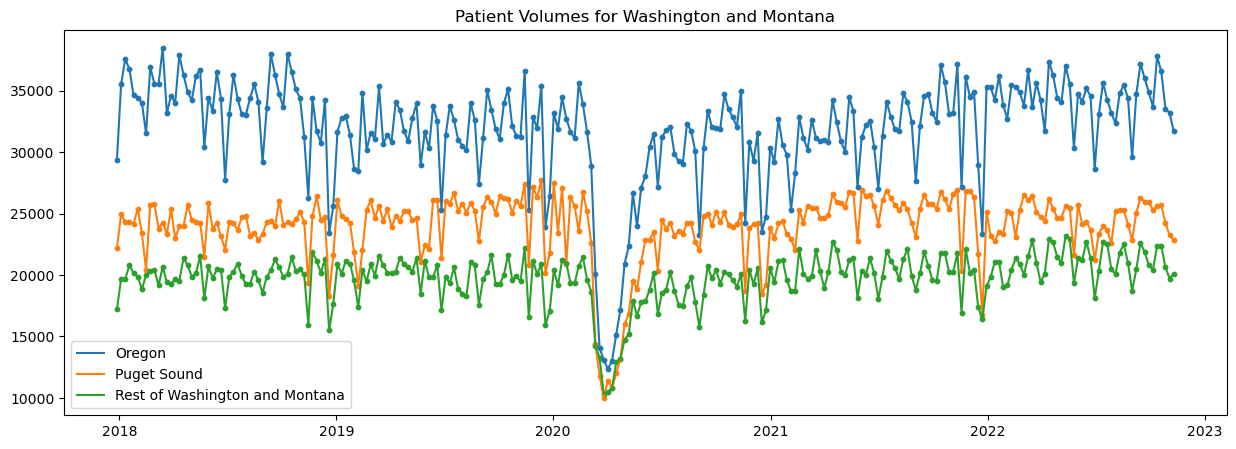

In [16]:
# plot of PS, WA/MT, and OR
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(t, df['Oregon'], label = 'Oregon')
ax.scatter(t, df['Oregon'], s = 10)
ax.plot(t, df['Puget Sound'], label = 'Puget Sound')
ax.scatter(t, df['Puget Sound'], s = 10)
ax.plot(t, df['WA/MT'], label = 'Rest of Washington and Montana')
ax.scatter(t, df['WA/MT'], s = 10)
ax.set_title('Patient Volumes')
ax.legend(loc = 'lower left')
ax.set_title('Patient Volumes for Washington and Montana')

Visually, the correlation appears quite strong. We can calculate the correlations for the present time as well as prior times for each region.

In [17]:
import statsmodels.api as sm

In [18]:
PS_WA = sm.tsa.stattools.ccf(df['Puget Sound'], df['WA/MT'], adjusted = False)
PS_WA[1:10]

array([0.54026578, 0.47731324, 0.41706963, 0.39591363, 0.35094303,
       0.22298724, 0.22028185, 0.16209486, 0.07077057])

In [19]:
PS_OR = sm.tsa.stattools.ccf(df['Puget Sound'], df['Oregon'], adjusted = False)
PS_OR[1:10]

array([0.54652138, 0.47663766, 0.43971738, 0.3830998 , 0.32993285,
       0.19394072, 0.20698556, 0.11333597, 0.05905611])

In [20]:
OR_WA = sm.tsa.stattools.ccf(df['Oregon'], df['WA/MT'], adjusted = False)
OR_WA[1:10]

array([0.54844016, 0.42655248, 0.39650617, 0.43604098, 0.37648343,
       0.22574753, 0.1662003 , 0.18753108, 0.13211058])

The present volume (lag 0) of patients in Oregon is moderately correlated (55%) with the patient volume of Puget Sound, and the correlation remains similarly high for subsequent weeks. The prior week volumes are correlated at 48%, decreasing slowly with each subsequent week. The fifth week delayed values are correlated at 33%, and by 9 weeks out the correlation is nearly 0. The correlation pattern is very similar for the Washington/Montana (WA/MT) and Puget Sound. We can use the past data from Oregon and WA/MT to attempt to predict the volumes for Puget Sound.

In [21]:
from statsmodels.tsa.api import VAR

In [22]:
dfsmall = df[['Puget Sound', 'WA/MT', 'Oregon']]
varmodel1 = VAR(dfsmall)
varmodel1.select_order(maxlags = 5).summary()

,AIC,BIC,FPE,HQIC
0,44.90,44.95,3.175e+19,44.92
1,43.83,44.00,1.087e+19,43.90
2,43.74,44.04,9.940e+18,43.86
3,43.63,44.05,8.841e+18,43.80
4,43.25*,43.80*,6.049e+18*,43.47*
5,43.27,43.94,6.171e+18,43.54


A fourth order model shows the lowest values for all information criteria (when examining lags up to 5). We could examine more lags later if we are unsatisfied with the predictions from the model. 

In [23]:
fitted_varmodel1 = varmodel1.fit(4)
fitted_varmodel1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     10:56:13
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    43.7823
Nobs:                     251.000    HQIC:                   43.4549
Log likelihood:          -6455.39    FPE:                5.97896e+18
AIC:                      43.2345    Det(Omega_mle):     5.13848e+18
--------------------------------------------------------------------
Results for equation Puget Sound
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const               5183.768071      1792.029930            2.893           0.004
L1.Puget Sound         0.605175         0.114251            5.297           0.000
L1.WA/MT              -0.192725         0.181131  

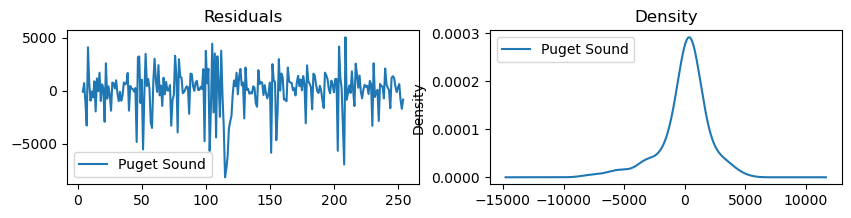

<Figure size 640x480 with 0 Axes>

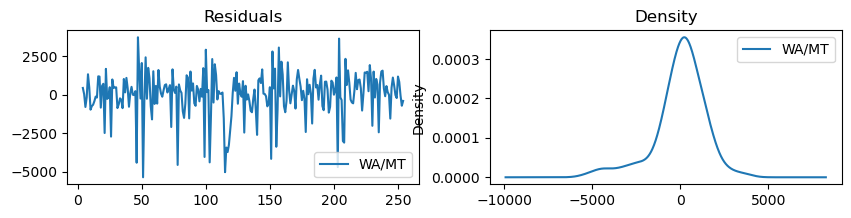

<Figure size 640x480 with 0 Axes>

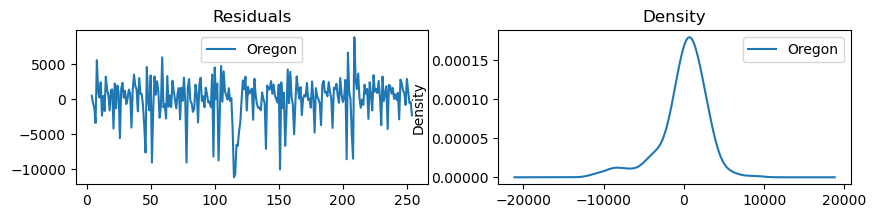

In [24]:
# residuals varmodel1
def res_plot(region):
    res = pd.DataFrame(fitted_varmodel1.resid[region])
    fig, ax = plt.subplots(1,2, figsize = (10,2))
    res.plot(title="Residuals", ax=ax[0])
    res.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()
res_plot('Puget Sound')
plt.figure(2)
res_plot('WA/MT')
plt.figure(3)
res_plot('Oregon')

In [25]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(fitted_varmodel1.resid)

array([2.03879343, 2.07869461, 2.01665109])

Aside from the usual Covid-19 related depression there are no systemic patterns or residual correlations to worry about. The errors are normally distributed with relatively constant variances. We can use this model to check some forecasts.

In [26]:
# create 'training' and 'testing' set
train = dfsmall[:250]
test = dfsmall[250:]
varmodel1 = VAR(train)
fitted_varmodel1 = varmodel1.fit(4)

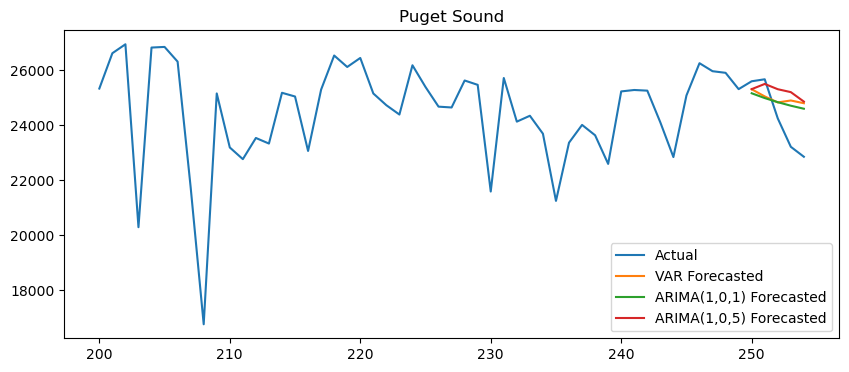

In [27]:
fc = fitted_varmodel1.forecast(y = train.values[:250], steps = 5)
fc = pd.DataFrame(fc)
fc['Index'] = np.arange(250,255,1)
fc = fc.set_index('Index')

# plot
plt.figure(figsize = (10,4))
plt.plot(dfsmall.loc[200:254, ['Puget Sound']], label = 'Actual')
plt.plot(fc[0], label = 'VAR Forecasted')
plt.plot(fc2_series, label = 'ARIMA(1,0,1) Forecasted')
plt.plot(fc3_series, label = 'ARIMA(1,0,5) Forecasted')
plt.xticks(np.arange(200,255,10))
plt.title("Puget Sound")
plt.legend()
plt.show()

The predictions don't look too different than the other models. How do they measure for other times? Using the same times we tested the other models on, we can see that this VAR model is much more accurate regardless of time. We again forecast 10 weeks ahead.

In [28]:
def pred_acc2(split, steps, region):
    train = dfsmall.loc[:split]
    test = dfsmall[split:split + steps]
    varmodel1 = VAR(train)
    fits = varmodel1.fit(4)
    fc = fits.forecast(y = train.values[:split], steps = steps)
    forecast = pd.DataFrame(fc)
    return(np.mean(np.abs(forecast[region] - test.iloc[:, region].values)/np.abs(test.iloc[:, region].values))) # MAPE

MAPE_VAR = list()
MAPE_2_0_1 = list()
MAPE_1_0_1 = list()
MAPE_1_0_5 = list()
testloc = (230, 200, 118, 95)
step = 10

for i in testloc:
    MAPE_VAR.append(round(pred_acc2(i, step, 0), 4))
    MAPE_2_0_1.append(round(pred_acc(2,0,1,step,i), 4))
    MAPE_1_0_1.append(round(pred_acc(1,0,1,step,i), 4))
    MAPE_1_0_5.append(round(pred_acc(1,0,5,step,i), 4))

print('Time: \t\t 230  \t  200  \t  118  \t  95')
print('VAR(4):\t     ', MAPE_VAR)
print('ARIMA(2,0,1):', MAPE_2_0_1)
print('ARIMA(1,0,1):', MAPE_1_0_1)
print('ARIMA(1,0,5):', MAPE_1_0_5)

Time: 		 230  	  200  	  118  	  95
VAR(4):	      [0.0485, 0.1168, 0.1757, 0.0997]
ARIMA(2,0,1): [0.0578, 0.1189, 0.4002, 0.1074]
ARIMA(1,0,1): [0.0571, 0.1189, 0.3927, 0.106]
ARIMA(1,0,5): [0.0515, 0.1207, 0.4518, 0.102]


The VAR(4) model is most accurate than any ARIMA model for any time, but especially in the 'Covid trough', where it is more than twice as accurate as the next best model. There are significant correlations between the 'next door' regions and our target region that improve the forecasts over simply using last week's data, especially when performing a relatively long range forecast of 10 weeks. This analysis has focused on the Puget Sound region, but could be replicated for any other region of our choosing.

# Appendix
Full Model Outputs:

In [32]:
# ARIMA(2,0,1) 
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Puget Sound   No. Observations:                  255
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -2306.012
Date:                Fri, 09 Dec 2022   AIC                           4622.024
Time:                        10:59:20   BIC                           4639.730
Sample:                             0   HQIC                          4629.146
                                - 255                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.394e+04    737.800     32.452      0.000    2.25e+04    2.54e+04
ar.L1          0.9639      0.245      3.936      0.000       0.484       1.444
ar.L2         -0.0841      0.169     -0.498      0.619      -0.415       0.247
ma.L1         -0.4631      0.224     -2.067      0.039      -0.902      -0.024
sigma2       4.25e+06   2.86e+05     14.851      0.000    3.69e+06    4.81e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.51
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -1.25
Prob(H) (two-sided):                  0.75   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
# ARIMA(1,0,1) model
model = ARIMA(df['Puget Sound'], order = (1,0,1))
model2 = model.fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Puget Sound   No. Observations:                  255
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2306.217
Date:                Fri, 09 Dec 2022   AIC                           4620.434
Time:                        11:00:31   BIC                           4634.599
Sample:                             0   HQIC                          4626.132
                                - 255                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.394e+04    716.256     33.428      0.000    2.25e+04    2.53e+04
ar.L1          0.8552      0.050     17.164      0.000       0.758       0.953
ma.L1         -0.3696      0.071     -5.196      0.000      -0.509      -0.230
sigma2      4.254e+06   2.86e+05     14.854      0.000    3.69e+06    4.82e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               175.68
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -1.25
Prob(H) (two-sided):                  0.74   Kurtosis:                         6.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
# ARIMA(1,0,5)
model = ARIMA(df['Puget Sound'], order = (1,0,5))
model3 = model.fit() 
print(model3.summary())

                               SARIMAX Results                                
Dep. Variable:            Puget Sound   No. Observations:                  255
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -2295.629
Date:                Fri, 09 Dec 2022   AIC                           4607.259
Time:                        11:00:11   BIC                           4635.589
Sample:                             0   HQIC                          4618.654
                                - 255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.394e+04    601.846     39.783      0.000    2.28e+04    2.51e+04
ar.L1          0.5636      0.133      4.240      0.000       0.303       0.824
ma.L1         -0.0213      0.136     -0.157      0.8